# TODO


## 5. Add barplots of validation results with the final features
## 6. Add barplots and graphs like in figure 4 in the paper



In [274]:
%reload_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from IPython.core.display import display, HTML

# display wide notebook cells
display(HTML("<style>.container { width:100% !important; }</style>"))

In [275]:
import feature_importance
import feature_selection
import functools
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import train_and_predict
import util

from data import *
from taxa import *
from train_and_predict import *
from visualization import *

from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline

# Read Data

In [5]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
path = Path('..\Data')

In [72]:
figs_output = Path('..\Paper\Figures')

In [6]:
train_genomes_path = path / 'train_genomes.fasta'
train_genomes_metedata_path = path / 'train_genomes_info.csv'

test_genomes_path = path / 'test_genomes.fasta'
test_genomes_metedata_path = path / 'test_genomes_verified.csv'

train_dataset = GenomesData(train_genomes_path, train_genomes_metedata_path)
test_dataset = GenomesData(test_genomes_path, test_genomes_metedata_path)

Check split train dataset to train and validation according to insertion date

In [280]:
print('train dataset', len(train_dataset.data))

split = feature_selection.split_by_insertion_date(train_dataset, proportion=0.2)

train_idx, validation_idx = next(split.split())

X_train_raw, X_valid_raw = train_dataset.data[train_idx], train_dataset.data[validation_idx]
y_train, y_valid = train_dataset.y[train_idx], train_dataset.y[validation_idx]

print('train', len(X_train_raw), 'validation', len(X_valid_raw))

train dataset 641
train 513 validation 128


In [243]:
y_valid.value_counts()

1    89
0    39
Name: Label, dtype: int64

In [244]:
DATE_INSERTED = 'Date Inserted'

min_validation_date = min(train_dataset.metadata.iloc[validation_idx, :][DATE_INSERTED])
min_validation_date

Timestamp('2018-11-29 03:53:53.656000+0000', tz='UTC')

In [245]:
max_train_date = max(train_dataset.metadata.iloc[train_idx, :][DATE_INSERTED])
max_train_date

Timestamp('2018-11-29 03:08:47.637000+0000', tz='UTC')

In [246]:
assert min_validation_date > max_train_date

# Feature Selection - best k features according to chi2

## 20% validation

In [56]:
min_val = 50
max_val = 600
inc = 50

k_range = range(min_val, max_val + 1, inc)

split = feature_selection.split_by_insertion_date(train_dataset, proportion=0.2)
grid_search = feature_selection.perform_fs_k_best(train_dataset, k_range, split=split)
print(grid_search.best_params_)

param_name = 'k_best__k'
kvals_df = feature_selection.grid_search_results_to_df(grid_search, param_name)

Best roc_auc score is: 0.9030538749639873
{'k_best__k': 450}


In [193]:
kvals_df

,mean_test_balanced_accuracy,mean_test_roc_auc
param_k_best__k,,
50,0.832,0.873
100,0.828,0.885
150,0.813,0.882
200,0.815,0.897
250,0.826,0.896
300,0.837,0.896
350,0.837,0.898
400,0.832,0.899
450,0.844,0.903


Validation results per k value


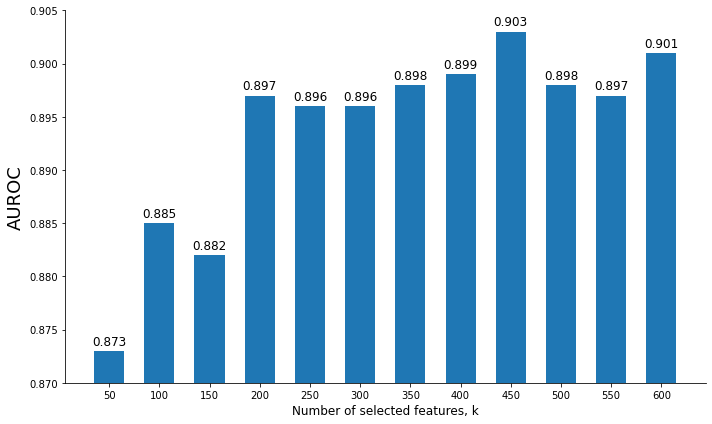

In [232]:
print('Validation results per k value')

fig_path = figs_output / 'feat_selection_k.pdf'

fs_dict = dict(zip(list(kvals_df.index), list(kvals_df['mean_test_roc_auc'])))
create_barplots(fs_dict, width=30, x_label='Number of selected features, k', y_label=AUROC, out_path=fig_path, round_by=3, bar_label_font_size=12)

# Feature Selection - select best feature from each cluster

In [276]:
min_val = 0
max_val = 0.61
inc = 0.03
t_range = np.arange(min_val, max_val, inc)

# created corr matrix using feature_selection.create_corr_matrix(X_train_raw, y_train) 
corr_matrix_path = path / 'X_train_corr_mat_0.8_k450.csv'
corr_matrix_train = pd.read_csv(corr_matrix_path, index_col=0)
dist_matrix_train = feature_selection.feature_corr_to_dist_matrix(corr_matrix_train)

split = feature_selection.split_by_insertion_date(train_dataset, proportion=0.2)
grid_search_cluster = feature_selection.perform_fs_clusters(train_dataset, dist_matrix_train, t_range, split=split)
print(grid_search_cluster.best_params_)

param_name = 'cluster__threshold'
thresholds_df = feature_selection.grid_search_results_to_df(grid_search_cluster, param_name)

fs clusters
threshold=0.00, selected_features=450
threshold=0.03, selected_features=406
threshold=0.06, selected_features=373
threshold=0.09, selected_features=329
threshold=0.12, selected_features=298
threshold=0.15, selected_features=270
threshold=0.18, selected_features=244
threshold=0.21, selected_features=219
threshold=0.24, selected_features=201
threshold=0.27, selected_features=181
threshold=0.30, selected_features=159
threshold=0.33, selected_features=136
threshold=0.36, selected_features=116
threshold=0.39, selected_features=95
threshold=0.42, selected_features=74
threshold=0.45, selected_features=60
threshold=0.48, selected_features=47
threshold=0.51, selected_features=37
threshold=0.54, selected_features=30
threshold=0.57, selected_features=18
threshold=0.60, selected_features=15
threshold=0.00, selected_features=450
Best roc_auc score is: 0.9030538749639873
{'cluster__threshold': 0.0}


Validation results per threshold value


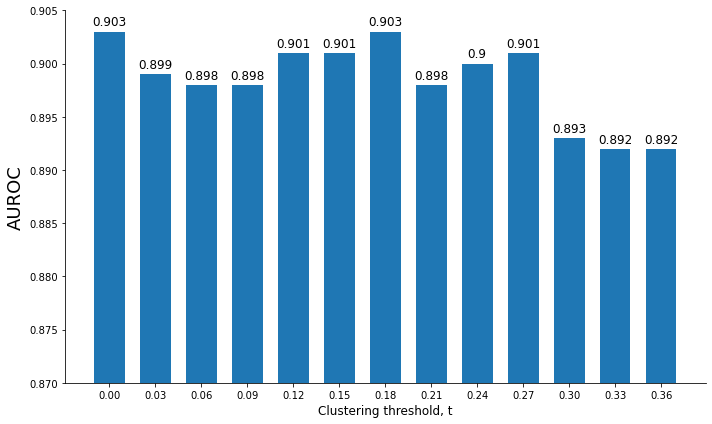

In [231]:
print('Validation results per threshold value')
thresholds_df_t036 = thresholds_df.loc[[i*0.03 for i in range(13)]]

fig_path = figs_output / 'feat_selection_t.pdf'
fs_dict = dict(zip(list(thresholds_df_t036.index), list(thresholds_df_t036['mean_test_roc_auc'])))

create_barplots(fs_dict, width=0.02, x_label='Clustering threshold, t', y_label=AUROC, out_path=fig_path, round_by=3, bar_label_font_size=12)

> Unfortunatly, there is no way to extract the number of selected features from grid search. Need to parse the printed text: "threshold=0.00, selected_features= 450
threshold=0.03, selected_features= 406..."

# Validation Results

In [283]:
best_k = 450
best_t = 0.18

no clustering

In [285]:
fs_pipeline = feature_selection.get_fs_pipeline(dist_matrix_train, k=best_k, threshold=0)

fs_pipeline.fit(X_train_raw, y_train)

results_valid_no_clust = predict_and_print_results(X_valid_raw, y_valid, fs_pipeline)

threshold=0.00, selected_features=450
false_positive: 6,total NHPs: 39
false_negative: 14,total HPs: 89
BACC: 0.84
Sensitivity: 0.84
Specificity: 0.85
AUPR: 0.95
AUROC: 0.9


In [282]:
fs_pipeline = feature_selection.get_fs_pipeline(dist_matrix_train, k=best_k, threshold=best_t)

fs_pipeline.fit(X_train_raw, y_train)

results_valid = predict_and_print_results(X_valid_raw, y_valid, fs_pipeline)

threshold=0.18, selected_features=244
false_positive: 6,total NHPs: 39
false_negative: 13,total HPs: 89
BACC: 0.85
Sensitivity: 0.85
Specificity: 0.85
AUPR: 0.94
AUROC: 0.9


# Final model

## Perform feature selection process on the entire train dataset, using best parameters

In [7]:
best_k = 450
best_t = 0.18

In [278]:
X_train_dataset_raw, X_test_raw = train_dataset.data, test_dataset.data
y_train_dataset, y_test = train_dataset.y, test_dataset.y

# created corr matrix using feature_selection.create_corr_matrix(X_train_dataset_raw, y_train, k=450) 
corr_matrix_path = path / 'X_train_corr_mat_k450.csv'
X_train_corr_matrix_k450 = pd.read_csv(corr_matrix_path, index_col=0)
X_train_dist_mat = feature_selection.feature_corr_to_dist_matrix(X_train_corr_matrix_k450)

fs_pipeline = feature_selection.get_fs_pipeline(X_train_dist_mat, k=best_k, threshold=best_t)

fs_pipeline.fit(X_train_dataset_raw, y_train_dataset)

results = predict_and_print_results(X_test_raw, y_test, fs_pipeline)

threshold=0.18, selected_features=250
false_positive: 21,total NHPs: 102
false_negative: 6,total HPs: 102
BACC: 0.87
Sensitivity: 0.94
Specificity: 0.79
AUPR: 0.96
AUROC: 0.95


In [271]:
y_train_dataset.value_counts()

1    428
0    213
Name: Label, dtype: int64

## Extract final features

In [235]:
all_pgfams = pd.array(fs_pipeline['vectorize'].get_feature_names())
k_best_pgfams = all_pgfams[fs_pipeline['k_best'].get_support()]
cluster_pgfams = k_best_pgfams[fs_pipeline['cluster'].get_support()]

# Examine features

In [11]:
len(all_pgfams)

393042

In [236]:
vectorizer = CountVectorizer(lowercase=False, binary=True, vocabulary=cluster_pgfams)
X_train_fs_clust = train_dataset.vectorize_data(vectorizer)

In [258]:
assert all(cluster_pgfams == vectorizer.get_feature_names())

In [259]:
assert all(cluster_pgfams == X_train_fs_clust.columns)

In [30]:
vectorizer = CountVectorizer(lowercase=False, binary=True, vocabulary=k_best_pgfams)
X_train_fs_k_best = train_dataset.vectorize_data(vectorizer)

In [31]:
chi2_vals, __ = sklearn.feature_selection.chi2(X_train_fs_k_best, y_train)
min(chi2_vals)

68.3802547338115

In [32]:
def get_hp_to_nhp_count(X, y, pgfam):
    return feature_importance.count_hp_vs_nhp(X[X[pgfam]==1].index, y)


pgfam_to_count_hp = {}
pgfam_to_count_nhp = {}

for pgfam in k_best_pgfams:
    hp, nhp = get_hp_to_nhp_count(X_train_fs_k_best, y_train, pgfam)
    if hp > nhp:
        pgfam_to_count_hp[pgfam] = hp
    else:
        pgfam_to_count_nhp[pgfam] = nhp


min(pgfam_to_count_hp.values()), min(pgfam_to_count_nhp.values())

(139, 35)

In [43]:
vectorizer = CountVectorizer(lowercase=False, binary=True, vocabulary=cluster_pgfams)
X_train_final_features = train_dataset.vectorize_data(vectorizer)

X_train_final_features_hp = X_train_final_features.loc[:, set(pgfam_to_count_hp.keys()).intersection(X_train_final_features.columns)]
X_train_final_features_nhp = X_train_final_features.loc[:, set(pgfam_to_count_nhp.keys()).intersection(X_train_final_features.columns)]

chi2_vals_final_hp, __ = sklearn.feature_selection.chi2(X_train_final_features_hp, y_train)
chi2_vals_final_nhp, __ = sklearn.feature_selection.chi2(X_train_final_features_nhp, y_train)

In [39]:
chi2_final_feats_hp = pd.Series(chi2_vals_final_hp, index=X_train_final_features_hp.columns)
chi2_final_feats_hp = chi2_final_feats_hp.sort_values(ascending=False)
chi2_final_feats_hp.head()

PGF_07157721    123.013500
PGF_04139053    121.163670
PGF_00006100    113.372253
PGF_00022550    112.402208
PGF_02280536    112.113190
dtype: float64

In [44]:
chi2_final_feats_nhp = pd.Series(chi2_vals_final_nhp, index=X_train_final_features_nhp.columns)
chi2_final_feats_nhp = chi2_final_feats_nhp.sort_values(ascending=False)
chi2_final_feats_nhp.head()

PGF_01667671    224.781054
PGF_02930287    211.080374
PGF_00033940    190.387663
PGF_10332317    185.342548
PGF_00401757    183.450463
dtype: float64

In [23]:
pgfams = {}

with open(path / 'PATRIC_pgfams_wspc.txt') as f:
    header = f.readline()

    for line in f:
        pgfam, product = line.strip().split('\t')
        pgfams[pgfam] = product

In [41]:
for pgfam in chi2_final_feats_hp.index[:15]:
    print(pgfams[pgfam])

"Heme O synthase, protoheme IX farnesyltransferase, COX10-CtaB"
Uroporphyrinogen III decarboxylase (EC 4.1.1.37)
tRNA-modifying protein YgfZ
Molybdopterin synthase catalytic subunit MoaE (EC 2.8.1.12)
Dienelactone hydrolase family protein
"YpfJ protein, zinc metalloprotease superfamily"
Cell division protein FtsQ
Deoxyribodipyrimidine photolyase (EC 4.1.99.3)
Cytosol aminopeptidase PepA (EC 3.4.11.1)
Flavodoxin reductases (ferredoxin-NADPH reductases) family 1
NADH-ubiquinone oxidoreductase chain E (EC 1.6.5.3)
Tol-Pal system protein TolQ
Nitrite reductase [NAD(P)H] large subunit (EC 1.7.1.4)
Luciferase-like monooxygenase YhbW
UPF0061 protein YdiU


In [45]:
for pgfam in chi2_final_feats_nhp.index[:15]:
    print(pgfams[pgfam])

Cytidylate kinase (EC 2.7.4.25)
Reverse rubrerythrin
Phosphoribosylaminoimidazolecarboxamide formyltransferase (EC 2.1.2.3)
Electron transport complex protein RnfB
no significant homology.
Flavoprotein
[FeFe] hydrogenase (EC 1.12.7.2)
Rubrerythrin
Activator of (R)-2-hydroxyglutaryl-CoA dehydratase
"Dihydroorotate dehydrogenase (NAD(+)), catalytic subunit (EC 1.3.1.14)"
Iron-sulfur flavoprotein
"L,L-diaminopimelate aminotransferase (EC 2.6.1.83)"
"RNA methyltransferase, TrmA family"
Flavodoxin
Flavoredoxin


#### Observe clusters to make sure they make sense

In [34]:
clusters = fs_pipeline['cluster'].clusters_
clusters.sort(key=lambda cluster: len(cluster), reverse=True)

In [35]:
for i, cluster in enumerate(clusters):
    print('cluster', i)
    for pgfam_ind in cluster:
        pgfam = k_best_pgfams[pgfam_ind]
        print(pgfam, pgfams[pgfam])
    print('-----------------')

cluster 0
PGF_00000939 Uncharacterized protein YhiN
PGF_00008469 Glutathione synthetase (EC 6.3.2.3)
PGF_00019484 Membrane alanine aminopeptidase N (EC 3.4.11.2)
PGF_00031127 Periplasmic thiol:disulfide interchange protein DsbA
PGF_00054476 Succinate dehydrogenase hydrophobic membrane anchor protein
PGF_00057016 "Tol biopolymer transport system, TolR protein"
PGF_00057028 Tol-Pal system peptidoglycan-associated lipoprotein PAL
PGF_00064460 Ubiquinone biosynthesis regulatory protein kinase UbiB
PGF_00064685 Uncharacterized ferredoxin-like protein YfhL
PGF_00415581 23S rRNA (uridine(2552)-2'-O)-methyltransferase (EC 2.1.1.166)
PGF_00417755 3-demethylubiquinol 3-O-methyltransferase (EC 2.1.1.64) @ 2-polyprenyl-6-hydroxyphenyl methylase (EC 2.1.1.222)
PGF_00423927 4-hydroxybenzoate polyprenyltransferase (EC 2.5.1.39)
PGF_00648054 Tol-Pal system protein TolQ
PGF_00649271 Cell division protein BolA
PGF_00906364 Hydroxyacylglutathione hydrolase (EC 3.1.2.6)
PGF_01785347 Adenosine (5')-pentaph

cluster 147
PGF_01676425 Alkaline shock protein
-----------------
cluster 148
PGF_01874968 Hypothetical protein Cj1505c
-----------------
cluster 149
PGF_01915472 Dihydrolipoamide acetyltransferase component of pyruvate dehydrogenase complex (EC 2.3.1.12)
-----------------
cluster 150
PGF_01937476 BioD-like N-terminal domain / Phosphate acetyltransferase (EC 2.3.1.8)
-----------------
cluster 151
PGF_01982773 "Acetyl-coenzyme A carboxyl transferase alpha chain (EC 6.4.1.2) / Acetyl-coenzyme A carboxyl transferase beta chain (EC 6.4.1.2); Propionyl-CoA carboxylase beta chain (EC 6.4.1.3); Methylmalonyl-CoA decarboxylase, alpha chain (EC 4.1.1.41)"
-----------------
cluster 152
PGF_02029456 "Ferrochelatase, protoheme ferro-lyase (EC 4.99.1.1)"
-----------------
cluster 153
PGF_02037786 "Enoyl-[acyl-carrier-protein] reductase [FMN, NADH] (EC 1.3.1.9), FabK => refractory to triclosan"
-----------------
cluster 154
PGF_02085373 UPF0225 protein YchJ
-----------------
cluster 155
PGF_02230794

# Correlation

In [241]:
corr_matrix_250_feats_path = path / 'X_train_corr_mat_selected_250_feats.csv'

In [238]:
len(X_train_fs_clust.columns)

250

In [239]:
create_matrix = False

if create_matrix:
    X_train_250_feats_corr_mat = X_train_fs_clust.corr(method=feature_selection.phi_coef)
    X_train_250_feats_corr_mat.to_csv(corr_matrix_250_feats_path)

In [247]:
X_train_250_feats_corr_mat = pd.read_csv(corr_matrix_250_feats_path, index_col=0)

In [248]:
X_train_250_feats_corr_mat.head()

,PGF_00003251,PGF_00004164,PGF_00004169,PGF_00004337,PGF_00006100,PGF_00006245,PGF_00006320,PGF_00006377,PGF_00006380,PGF_00007119,...,PGF_10368922,PGF_10424554,PGF_10470483,PGF_10471787,PGF_10474010,PGF_10506571,PGF_10522720,PGF_10535492,PGF_12758906,PGF_12946886
PGF_00003251,1.000000,0.045217,0.116374,0.168262,0.360630,0.346004,0.346004,0.213321,0.311025,0.364685,...,0.142193,0.214516,0.165513,0.162796,0.286988,0.339711,0.017465,0.293345,0.310118,0.246512
PGF_00004164,0.045217,1.000000,0.330269,0.359142,0.349617,0.268387,0.188720,0.430382,0.249400,0.166379,...,0.272495,0.209224,0.217689,0.247273,0.275260,0.265726,0.530056,0.252031,0.161876,0.224426
PGF_00004169,0.116374,0.330269,1.000000,0.625801,0.373544,0.340748,0.331439,0.443322,0.287668,0.471309,...,0.688182,0.190276,0.410318,0.140015,0.292063,0.260030,0.497373,0.269891,0.351861,0.438752
PGF_00004337,0.168262,0.359142,0.625801,1.000000,0.371939,0.339613,0.349120,0.388367,0.249351,0.348001,...,0.590163,0.192658,0.600034,0.321628,0.292962,0.268000,0.411042,0.270487,0.493369,0.458840
PGF_00006100,0.360630,0.349617,0.373544,0.371939,1.000000,0.648785,0.648785,0.592796,0.557968,0.549171,...,0.345447,0.584820,0.289622,0.302283,0.729813,0.735041,0.425072,0.760420,0.273308,0.469013


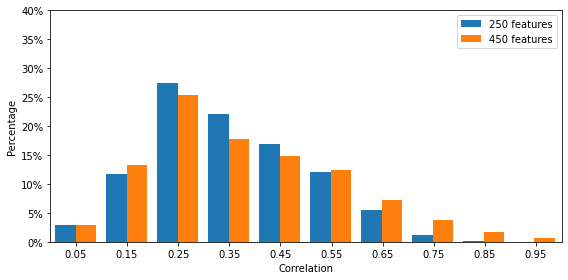

In [269]:
corr_250features = [i for i in X_train_250_feats_corr_mat.values.flatten() if i != 1]
corr_450features = [i for i in X_train_corr_matrix_k450.values.flatten() if i != 1]

dataset_names = ['250 features', '450 features']

fig_path = figs_output / 'feature_correlation.pdf'

create_correlation_plot(corr_250features, corr_450features, dataset_names, out_path=fig_path)

## Final WSPC model
A random forest model, which includes the selected genes as features

In [272]:
WSPC, results = train_and_predict(X_train_dataset_raw, y_train_dataset, X_test_raw, y_test, features=cluster_pgfams)

false_positive: 21,total NHPs: 102
false_negative: 6,total HPs: 102
BACC: 0.87
Sensitivity: 0.94
Specificity: 0.79
AUPR: 0.96
AUROC: 0.95


In [117]:
predictions, predictions_probs = predict(X_test_raw, WSPC)

In [265]:
predict_df = pd.DataFrame({'predictions':predictions, 'predictions_probs':predictions_probs}, index=X_test_raw.index)
predict_df.head()

,predictions,predictions_probs
Genome ID,,
163603.4,1,0.62
648.157,1,0.98
565.15,1,0.93
29459.655,1,1.00
87883.284,1,0.99


In [266]:
save = False

if save:
    # save predictions
    path = Path('..\comp_analysis')
    predict_df.to_csv(path/'wspc_test_preds.csv')
    
    #save model
    out_path = r'..\WSPC Model'
    model_filename = 'WSPC_model'
    util.save_model(out_path, model_filename, WSPC)

## Novel species

In [47]:
SPECIES = 'species'
GENUS = 'genus'

All classified species in train

In [80]:
train_species = set(get_first_tax_desc(genome, SPECIES) for genome in train_dataset.data.index if not get_unclassified_species(genome))

In [81]:
len(train_species)

536

In [82]:
train_genera = set(get_first_tax_desc(genome, GENUS) for genome in train_dataset.data.index)

In [83]:
len(train_genera)

200

In [84]:
test_genera = set(get_first_tax_desc(genome, GENUS) for genome in test_dataset.data.index)
len(test_genera)

93

In [85]:
test_species = set(get_first_tax_desc(genome, SPECIES) for genome in test_dataset.data.index if not get_unclassified_species(genome))

All classified species in test

In [86]:
len(test_species)

169

In [87]:
test_species_not_in_train = test_species - train_species

In [88]:
len(test_species_not_in_train)

63

In [89]:
test_novel_genome_ids = [genome for genome in X_test_raw.index if get_first_tax_desc(genome, SPECIES) in test_species_not_in_train]

In [118]:
novel_species_results = predict_and_print_results(X_test_raw[test_novel_genome_ids], y_test[test_novel_genome_ids], WSPC)

false_positive: 7,total NHPs: 31
false_negative: 6,total HPs: 32
BACC: 0.79
Sensitivity: 0.81
Specificity: 0.77
AUPR: 0.89
AUROC: 0.87


# Groups

In [107]:
GROUP = 'Group'
ONHP = 'ONHP'

In [108]:
test_dataset.metadata[GROUP].value_counts()

OHP     77
NHP     61
ONHP    41
HP      25
Name: Group, dtype: int64

In [109]:
test_dataset.metadata.loc[test_novel_genome_ids][GROUP].value_counts()

OHP     27
NHP     19
ONHP    12
HP       5
Name: Group, dtype: int64

## Remove ONHP genomes

In [110]:
test_no_onhp_genome_ids = [genome for genome in test_dataset.metadata.index if test_dataset.metadata.loc[genome, GROUP] != ONHP]

In [111]:
len(test_no_onhp_genome_ids)

163

In [112]:
results_no_onhp = predict_and_print_results(X_test_raw[test_no_onhp_genome_ids], y_test[test_no_onhp_genome_ids], WSPC)

false_positive: 4,total NHPs: 61
false_negative: 6,total HPs: 102
BACC: 0.94
Sensitivity: 0.94
Specificity: 0.93
AUPR: 0.99
AUROC: 0.98


Novel species

In [113]:
test_novel_no_onhp_genome_ids = set(test_novel_genome_ids).intersection(test_no_onhp_genome_ids)
len(test_novel_no_onhp_genome_ids)

51

In [114]:
novel_species_results_no_onhp = predict_and_print_results(X_test_raw[test_novel_no_onhp_genome_ids], y_test[test_novel_no_onhp_genome_ids], WSPC)

false_positive: 2,total NHPs: 19
false_negative: 6,total HPs: 32
BACC: 0.85
Sensitivity: 0.81
Specificity: 0.89
AUPR: 0.96
AUROC: 0.93


# Plot Results

In [92]:
def results_barplots(results, round_by=2):
    
    fig, ax = plt.subplots(figsize=(8,6))
    
    for key, value in results.items():
        ax.bar(*zip(*value.items()))
        
    ax.set_ylabel('Scores',  fontsize=18)
    #ax.set_xticklabels(results.keys(), fontsize=14)
    ax.set_ylim([0.1, 1.05])
    add_bar_labels(ax, round_by)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.show()  

In [120]:
ENTIRE_TEST = 'Entire Test'
NOVEL_SPECIES = 'Novel Species'

In [121]:
results_for_plot = {ENTIRE_TEST: results, NOVEL_SPECIES: novel_species_results}

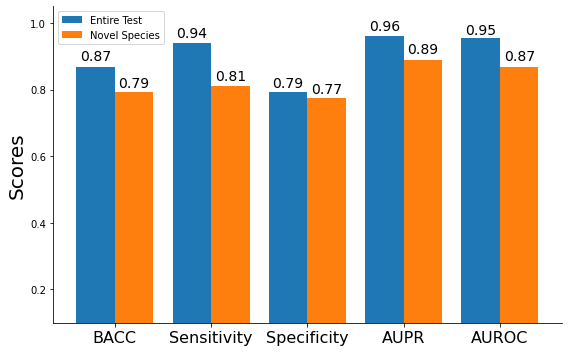

In [289]:
bar_groups = [BACC, SEN, SPE, AUPR, AUROC]
bars = [ENTIRE_TEST, NOVEL_SPECIES]

fig_path = figs_output / 'wspc_test_results.pdf'
create_grouped_barplots(results_for_plot, bar_groups, bars, out_path=fig_path, fig_size=(8, 5), bar_width=0.4, legend_loc='upper left', x_ticks_font_size=16)